**Part 1 ‑ Exploratory data analysis**
The attached logins.json file contains (simulated) timestamps of user logins in a particular
geographic location. Aggregate these login counts based on 15­minute time intervals, and
visualize and describe the resulting time series of login counts in ways that best characterize the
underlying patterns of the demand. Please report/illustrate important features of the demand,
such as daily cycles. If there are data quality issues, please report them.


In [25]:
import pandas as pd
import numpy as np
import json
from datetime import datetime

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
logins = pd.read_json('logins.json')

### Data Exploration

In [3]:
logins.describe()

,login_time
count,93142
unique,92265
top,1970-02-12 11:16:53
freq,3
first,1970-01-01 20:12:16
last,1970-04-13 18:57:38


In [4]:
logins.info() # already in datetime, no need to convert.

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 1 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
dtypes: datetime64[ns](1)
memory usage: 727.8 KB


In [5]:
logins.isnull().sum() # no missing values

login_time    0
dtype: int64

In [6]:
logins['day'] = logins['login_time'].dt.weekday
logins = logins.astype({"day":'category'})
logins_day = logins['day'].value_counts()
logins_day

5    19377
6    18167
4    15208
3    11960
2    10339
1     9268
0     8823
Name: day, dtype: int64

In [7]:
logins.tail()

,login_time,day
93137,1970-04-13 18:50:19,0
93138,1970-04-13 18:43:56,0
93139,1970-04-13 18:54:02,0
93140,1970-04-13 18:57:38,0
93141,1970-04-13 18:54:23,0


**Highest logins are on Saterday, followed by Sunday**

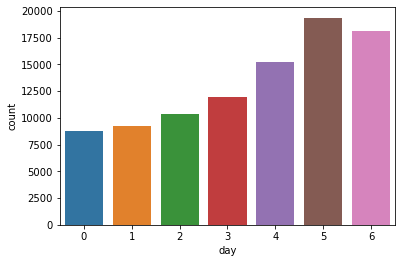

In [8]:
#Monday=0
sns.countplot(logins['day']);

In [9]:
logins['month'] = logins['login_time'].dt.month
logins = logins.astype({"month":'category'})
logins['month'].value_counts()

3    33723
2    24673
1    21239
4    13507
Name: month, dtype: int64

**Busiest month is March, followed by February**. This is misleading, as we'll see after further analysis.

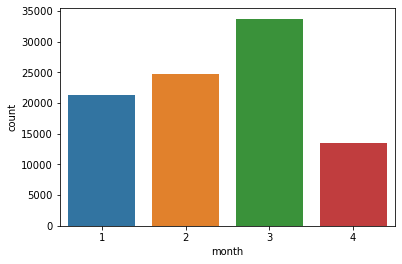

In [10]:
sns.countplot(logins['month']);

In [11]:
logins.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 93142 entries, 0 to 93141
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   login_time  93142 non-null  datetime64[ns]
 1   day         93142 non-null  category      
 2   month       93142 non-null  category      
dtypes: category(2), datetime64[ns](1)
memory usage: 910.3 KB


In [12]:
#set the login_time as a datetimeIndex
logins.set_index('login_time', inplace=True)

In [13]:
logins.head()

,day,month
login_time,,
1970-01-01 20:13:18,3,1
1970-01-01 20:16:10,3,1
1970-01-01 20:16:37,3,1
1970-01-01 20:16:36,3,1
1970-01-01 20:26:21,3,1


In [14]:
logins.info() #check logins have been changed to datetimeIndex

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 93142 entries, 1970-01-01 20:13:18 to 1970-04-13 18:54:23
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype   
---  ------  --------------  -----   
 0   day     93142 non-null  category
 1   month   93142 non-null  category
dtypes: category(2)
memory usage: 910.1 KB


#### Re-sample every 15mins and visualize

In [15]:
logins_15 = logins.resample('15T') # resample to 15min intervals

In [16]:
logins_15_total = logins_15.count() # total logins in every 15mins

In [17]:
logins_15_total.describe()

,day,month
count,9788.000000,9788.000000
mean,9.515938,9.515938
std,8.328818,8.328818
min,0.000000,0.000000
25%,3.000000,3.000000
50%,7.000000,7.000000
75%,13.000000,13.000000
max,73.000000,73.000000


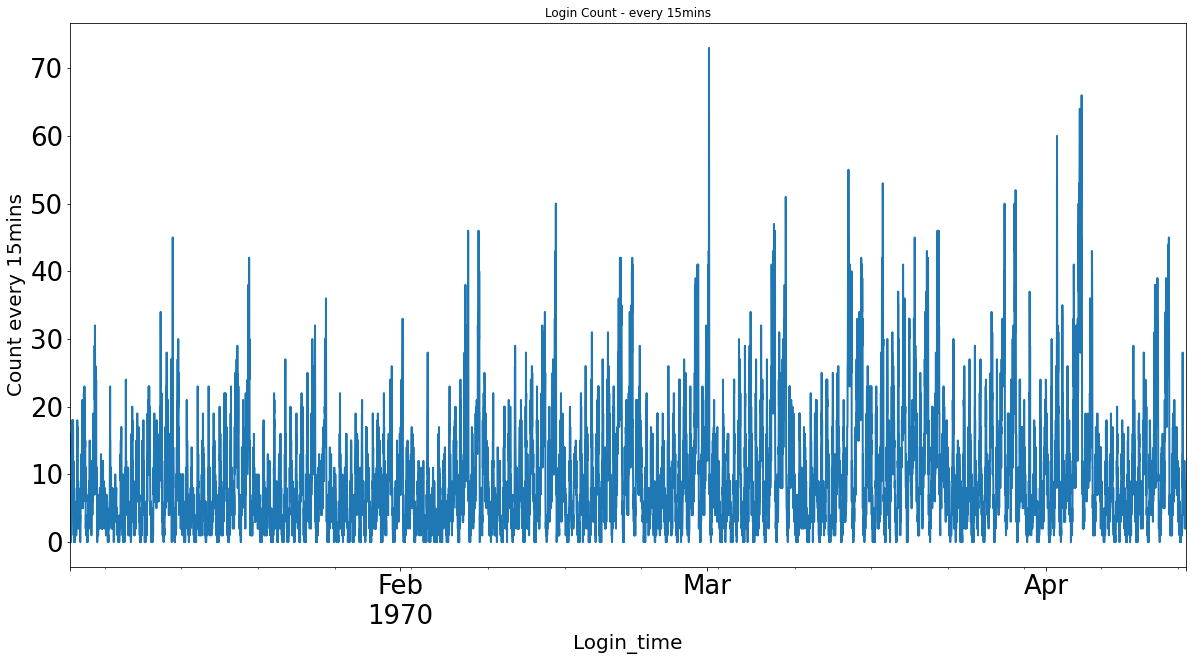

In [18]:
logins_15_total['day'].plot(figsize=(20,10),linewidth=2,
                     title="Login Count - every 15mins", fontsize=26)
plt.ylabel('Count every 15mins', fontsize=20)
plt.xlabel('Login_time', fontsize=20);

We can see the cyclical nature of logins. There is high frequency short term logins superimposed on lower frequency, weekly trend. Qualitatively speaking, there seems to be about 4 of these lower frequency trends, which matches our above, initial findings according to days of the week.<br>
The trend is better observed in the plot below, which has been resampled by day. All the high frequency counts are summed to give a lower frequency, total count.

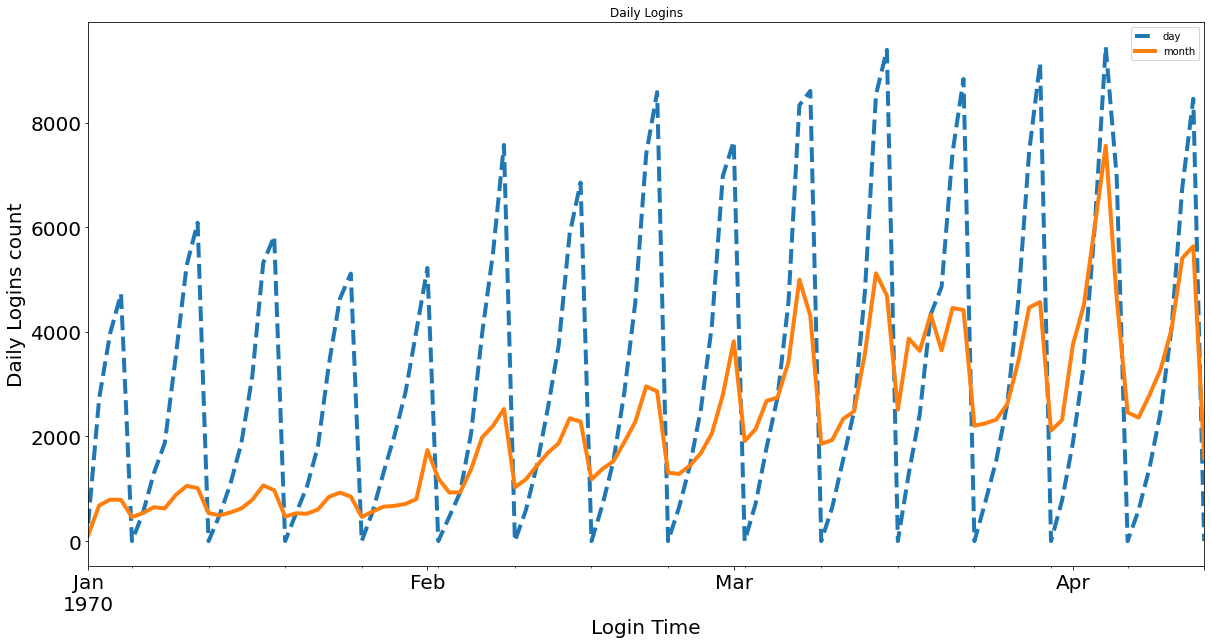

In [23]:
logins_daily2 = logins.resample('D').sum()
logins_daily2.plot(fontsize=20,title='Daily Logins', figsize=(20,10),linewidth=4, 
                  style=[ '--', '-']);
plt.ylabel('Daily Logins count', fontsize=20)
plt.xlabel('Login Time', fontsize=20);


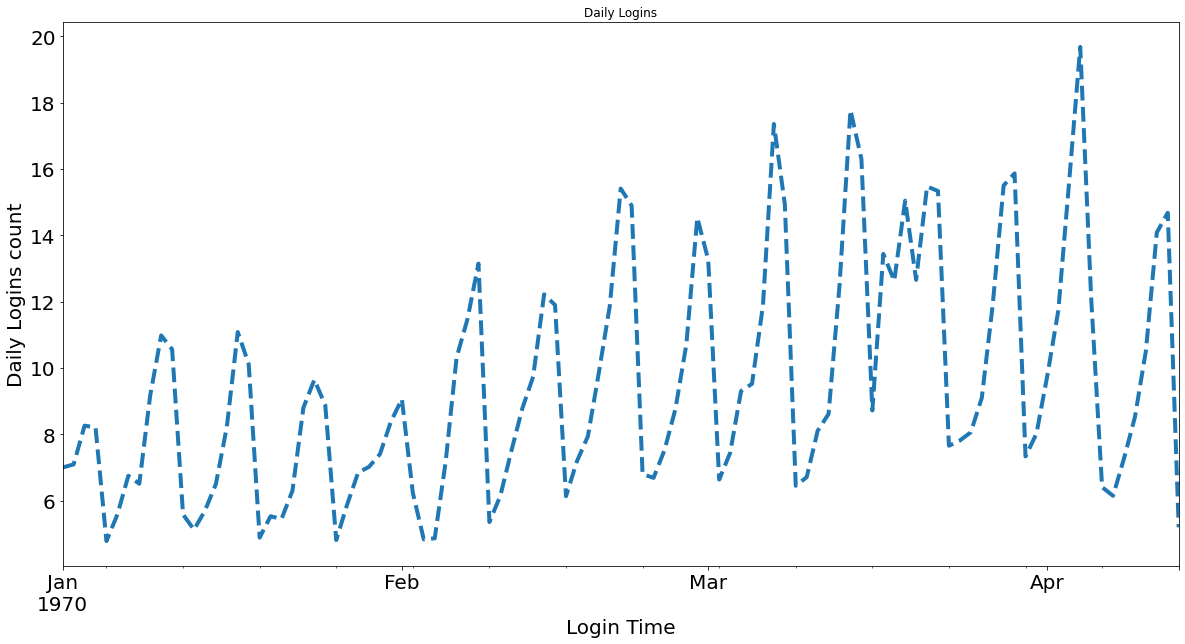

In [91]:
logins_daily = logins_15_total['day'].resample('D').mean()
logins_daily.plot(fontsize=20,title='Daily Logins', figsize=(20,10),linewidth=4, 
                  style=[ '--', '-']);
plt.ylabel('Daily Logins count', fontsize=20)
plt.xlabel('Login Time', fontsize=20);


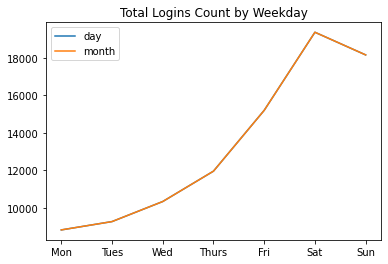

In [95]:
by_weekday = logins_15_total.groupby(logins_15_total.index.dayofweek).sum()
#by_weekday2 = logins_15_total.groupby(logins_15_total.index.dayofweek).sum()
by_weekday.index = ['Mon', 'Tues', 'Wed', 'Thurs', 'Fri', 'Sat', 'Sun']
by_weekday.plot(title='Total Logins Count by Weekday');

In [96]:
by_weekday

,day,month
Mon,8823,8823
Tues,9268,9268
Wed,10339,10339
Thurs,11960,11960
Fri,15208,15208
Sat,19377,19377
Sun,18167,18167


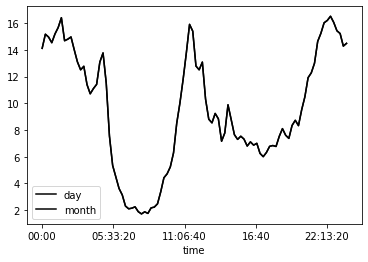

In [112]:
by_time = logins_15_total.groupby(logins_15_total.index.time).mean()
hourly_ticks = 4 * 60 * 60 * np.arange(6)
by_time.plot(color='black');#(xticks=hourly_ticks, color='magenta');

The daily login rate dips drastically between 5-11am.

In [120]:
weekend = np.where(logins_15_total.index.weekday < 5, 'Weekday', 'Weekend')
by_time = logins_15_total['day'].groupby([weekend, logins_15_total.index.time]).mean()

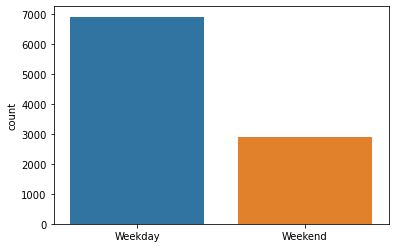

In [121]:
sns.countplot(weekend);

In [122]:
by_time.tail()

Weekend  22:45:00    15.300000
         23:00:00    13.133333
         23:15:00    13.100000
         23:30:00    12.566667
         23:45:00    13.300000
Name: day, dtype: float64

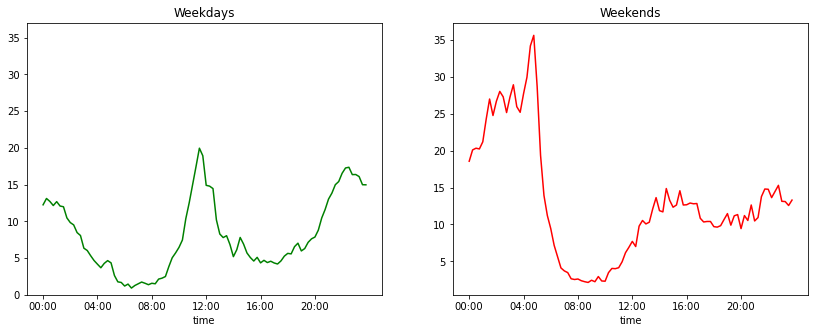

In [124]:
# Plot weekend and weekday trends:
fig, ax = plt.subplots(1, 2, figsize=(14, 5))
by_time.loc['Weekday'].plot(ax=ax[0], title='Weekdays',
                           xticks=hourly_ticks, color='g', ylim=[0,37])
by_time.loc['Weekend'].plot(ax=ax[1], title='Weekends',
                           xticks=hourly_ticks, color='r');

Another visual on how the weekend logins are more than during the weekday.

We can also see the spike in March. April also seems to be a month of high logins, but we do not have the record for the *entire* month. This is a problem since if we *only* look at the countplot for the month, we would mistakenly conclude that February has the second highest logins. 

### Summary:

- There are no missing values in this dataset.<br>
- Even in the 'raw' unfiltered plots we are able to see the cyclical nature of the logins during the month. There are four cycles in each month representing the number of weeks present. Each week has a peak and a trough, where the demand flows and ebbs. <br>
- There is a steady increase in logins from January to April.<br>
- Weekends, generally, see higher logins, and<br>
- The lowest login rates are between the hours of 5 - 11 am.

### Part 2 ‑ Experiment and metrics design
The neighboring cities of Gotham and Metropolis have complementary circadian rhythms: on
weekdays, Ultimate Gotham is most active at night, and Ultimate Metropolis is most active
during the day. On weekends, there is reasonable activity in both cities.
However, a toll bridge, with a two­way toll, between the two cities causes driver partners to tend
to be exclusive to each city. The Ultimate managers of city operations for the two cities have
proposed an experiment to encourage driver partners to be available in both cities, by
reimbursing all toll costs.

1. What would you choose as the key measure of success of this experiment in
encouraging driver partners to serve both cities, and why would you choose this metric?

Ans: <br>
I would count the number of drivers from each city crossing the toll bridge each day, day and night, and on weekends: <br>
'Gd': Gotham drivers crossing to Metropolis, and<br>
'Md': Metropolis drivers crossing to Gotham over the toll bridge. <br>

This is easy to implement, since tickets are usually issued in one of two ways. Either electronically(and each electronic card will be registered to a specific driver or driving company), or as a paper ticket, which can be collected from each driver upon reimburesment, and counted.<br>

A higher number of crossings(after the implementation of the reimburesement program), would indicate the presence of each in the other city. The assumption here is that 'Gd's and 'Md's would cross-over as part of a job, and are not merely going for personal errands. 

2. Describe a practical experiment you would design to compare the effectiveness of the
proposed change in relation to the key measure of success. Please provide details on:<br>

**a. how you will implement the experiment**<br>
Before the start of the incentive program, we'd count the number of drivers crossing the bridge . This would be carried out for a period of time, preferably long enough to get unbiased data, e.g. not during Christmas only, or school summer vacations. This would represent the 'before' situation.<br>

After the reimburesement of the toll tickets is declared/advertised, another survey would be conducted on the number of drivers crossing back and forth. This count would be at the 'reimburesemnt location' and compared to the count obtained at the tollbooth. This would be labelled the 'after' group. Comparing the two could be a measure of 'awarness' of the drivers about this program. The expectation is that, initially, there might be less drivers going for the reimbursement, but after a while, morse drivers would become aware of this program. The latter situaion would contian the 'better' data to use.<br>


**b. what statistical test(s) you will conduct to verify the significance of the
observation.**<br>
Once we have the *before* and *after* counts, we would conduct a t-test with the mean of the  two groups. If there is a significant difference between the two, this would indicate that the two groups are distinguishable.<br>

**c. how you would interpret the results and provide recommendations to the city
operations team along with any caveats.**<br>
If the number of drivers crossing over the toll bridge goes up after the reimbursement program is declared, this would indicate less exclusivity. The analysis would also groupby day/night/weekend in order to compare the counts during those times. If the program is successful, We would expect to see *more* Gotham drivers during the day on weekdays, and *more* Metropolis drivers at nigh, which is the opposite of the circadian rhythms of the two cities.<br>

However, before implementation, I would get the input of the domain experts in the city and transportation departments, in order to find the optimum way to implement this program(e.g. best way to get driver crossing counts). Also, I would find out if there are any reservations or pitfalls they see in this program, before moving to its implementation.

### Part 3 ‑ Predictive modeling
Ultimate is interested in predicting rider retention. To help explore this question, we have
provided a sample dataset of a cohort of users who signed up for an Ultimate account in
January 2014. The data was pulled several months later; we consider a user retained if they
were “active” (i.e. took a trip) in the preceding 30 days.<br>
We would like you to use this data set to help understand what factors are the best predictors
for retention, and offer suggestions to operationalize those insights to help Ultimate.<br>
The data is in the attached file ultimate_data_challenge.json. See below for a detailed
description of the dataset. Please include any code you wrote for the analysis and delete the
dataset when you have finished with the challenge.<br>
1. Perform any cleaning, exploratory analysis, and/or visualizations to use the provided
data for this analysis (a few sentences/plots describing your approach will suffice). What
fraction of the observed users were retained?<br>
2. Build a predictive model to help Ultimate determine whether or not a user will be active
in their 6th month on the system. Discuss why you chose your approach, what
alternatives you considered, and any concerns you have. How valid is your model?
Include any key indicators of model performance.<br>
3. Briefly discuss how Ultimate might leverage the insights gained from the model to
improve its long­term rider retention (again, a few sentences will suffice).


In [26]:
ultimate_data = pd.read_json('ultimate_data_challenge.json')

In [27]:
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9


In [28]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   city                    50000 non-null  object 
 1   trips_in_first_30_days  50000 non-null  int64  
 2   signup_date             50000 non-null  object 
 3   avg_rating_of_driver    41878 non-null  float64
 4   avg_surge               50000 non-null  float64
 5   last_trip_date          50000 non-null  object 
 6   phone                   49604 non-null  object 
 7   surge_pct               50000 non-null  float64
 8   ultimate_black_user     50000 non-null  bool   
 9   weekday_pct             50000 non-null  float64
 10  avg_dist                50000 non-null  float64
 11  avg_rating_by_driver    49799 non-null  float64
dtypes: bool(1), float64(6), int64(1), object(4)
memory usage: 4.2+ MB


In [59]:
# Convert objects to categorical variables, where it applies:
ultimate_data = ultimate_data.astype({"city":'category', "phone":'category'})

In [60]:
ultimate_data.describe()

,trips_in_first_30_days,avg_rating_of_driver,avg_surge,surge_pct,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip,retained,rider_duration,signup_month,signup_day
count,50000.000000,41878.000000,50000.000000,50000.000000,50000.000000,50000.000000,49799.000000,50000,50000.000000,50000.000000,50000.0,50000.000000
mean,2.278200,4.601559,1.074764,8.849536,60.926084,5.796827,4.778158,72 days 15:57:55.008000,0.376080,3.042320,1.0,0.322660
std,3.792684,0.617338,0.222336,19.958811,37.081503,5.707357,0.446652,61 days 17:15:20.288309,0.484405,1.992879,0.0,0.467499
min,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0 days 00:00:00,0.000000,0.000000,1.0,0.000000
25%,0.000000,4.300000,1.000000,0.000000,33.300000,2.420000,4.700000,13 days 00:00:00,0.000000,1.000000,1.0,0.000000
50%,1.000000,4.900000,1.000000,0.000000,66.700000,3.880000,5.000000,54 days 00:00:00,0.000000,4.000000,1.0,0.000000
75%,3.000000,5.000000,1.050000,8.600000,100.000000,6.940000,5.000000,137 days 00:00:00,1.000000,5.000000,1.0,1.000000
max,125.000000,5.000000,8.000000,100.000000,100.000000,160.960000,5.000000,181 days 00:00:00,1.000000,6.000000,1.0,1.000000


In [61]:
ultimate_data.isnull().sum()

city                         0
trips_in_first_30_days       0
signup_date                  0
avg_rating_of_driver      8122
avg_surge                    0
last_trip_date               0
phone                      396
surge_pct                    0
ultimate_black_user          0
weekday_pct                  0
avg_dist                     0
avg_rating_by_driver       201
days_since_last_trip         0
retained                     0
rider_duration               0
signup_month                 0
signup_day                   0
dtype: int64

In [62]:
#convert data to appropriate types:
ultimate_data['signup_date'] =  pd.to_datetime(ultimate_data['signup_date'])
ultimate_data['last_trip_date'] = pd.to_datetime(ultimate_data['last_trip_date'])
ultimate_data.astype({'phone':'category', 'city':'category'}).dtypes

city                             category
trips_in_first_30_days              int64
signup_date                datetime64[ns]
avg_rating_of_driver              float64
avg_surge                         float64
last_trip_date             datetime64[ns]
phone                            category
surge_pct                         float64
ultimate_black_user                  bool
weekday_pct                       float64
avg_dist                          float64
avg_rating_by_driver              float64
days_since_last_trip      timedelta64[ns]
retained                            int64
rider_duration                      int64
signup_month                        int64
signup_day                          int32
dtype: object

In [63]:
#ultimate_subset = ultimate_data.dropna()

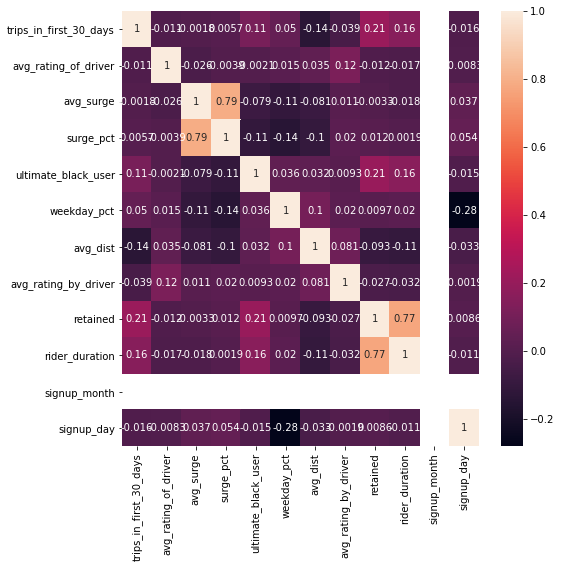

In [64]:
plt.figure(figsize=(8,8))
sns.heatmap(ultimate_data.corr(),annot=True);

In [65]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    50000 non-null  category       
 1   trips_in_first_30_days  50000 non-null  int64          
 2   signup_date             50000 non-null  datetime64[ns] 
 3   avg_rating_of_driver    41878 non-null  float64        
 4   avg_surge               50000 non-null  float64        
 5   last_trip_date          50000 non-null  datetime64[ns] 
 6   phone                   49604 non-null  category       
 7   surge_pct               50000 non-null  float64        
 8   ultimate_black_user     50000 non-null  bool           
 9   weekday_pct             50000 non-null  float64        
 10  avg_dist                50000 non-null  float64        
 11  avg_rating_by_driver    49799 non-null  float64        
 12  days_since_last_trip    50000 no

In [66]:
max_date = max(ultimate_data['last_trip_date']) # maximum date in dataset

Calculate retention, 1=retained, 0=not retained

In [67]:
ultimate_data['days_since_last_trip'] = max_date - ultimate_data['last_trip_date']
dlt = ultimate_data['days_since_last_trip']
rtnd = []   
for n_days in dlt:
    if n_days.days <= 30:
        rtnd.append(1)
    else:
        rtnd.append(0)   
        
ultimate_data['retained'] = rtnd

37.6% retention!

In [68]:
# Retained are 37.6%
ultimate_data['retained'].value_counts(normalize=True)

0    0.62392
1    0.37608
Name: retained, dtype: float64

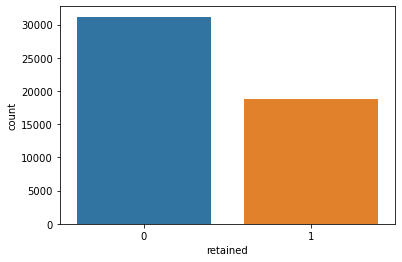

In [69]:
sns.countplot(ultimate_data['retained']);

In [70]:
ultimate_data[['last_trip_date', 'days_since_last_trip', 'retained']].tail()

,last_trip_date,days_since_last_trip,retained
49995,2014-06-05,26 days,1
49996,2014-01-25,157 days,0
49997,2014-05-22,40 days,0
49998,2014-01-15,167 days,0
49999,2014-04-20,72 days,0


In [71]:
ultimate_data[['signup_date', 'last_trip_date']].head()

,signup_date,last_trip_date
0,2014-01-25,2014-06-17
1,2014-01-29,2014-05-05
2,2014-01-06,2014-01-07
3,2014-01-10,2014-06-29
4,2014-01-27,2014-03-15


In [72]:
ultimate_data.groupby(['phone','city'])['retained'].value_counts().unstack(level=0).sum()

phone
Android    15022
iPhone     34582
dtype: int64

In [73]:
ultimate_data.groupby(['phone','city'])['retained'].value_counts().unstack(level=1).sum()

city
Astapor           16413
King's Landing    10066
Winterfell        23125
dtype: int64

In [74]:
ultimate_data.groupby(['phone','city'])['retained'].value_counts().unstack(level=0)

phone                    Android  iPhone
city           retained                 
Astapor        0            4599    7616
               1             645    3553
King's Landing 0            1406    2335
               1            1092    5233
Winterfell     0            5871    9106
               1            1409    6739

In [75]:
ultimate_data.groupby(['ultimate_black_user'])['retained'].value_counts().unstack(level=0)

ultimate_black_user,False,True
retained,,
0,21839,9357
1,9307,9497


In [76]:
ultimate_data.groupby(['retained'])['weekday_pct'].mean()

retained
0    60.647032
1    61.389034
Name: weekday_pct, dtype: float64

### 1. Answer Summary:
- Twice as many users have iphones than Androids.
- Majority of users are from Winterfell(23125) out of which only 8148 are retained.
- Most number of retained users are from Winterfell.
- Only37.6% of riders were retained. Retained is defined as having been active in the last 30days.
- There is a low retention rate among 'ultimate_black_user's.
- On average, retained and un-retained users took the same number of trips during the week.
- There were some missing values in the dataset which have been ignored thurs far, they are:<br>
avg_rating_of_driver 8122 | phone 396 | avg_rating_by_driver 201.<br>
Those rows will be dropped during the first modeling trials, and will be filled for the second modelling trials.

In [77]:
ultimate_data['rider_duration'] = ultimate_data['last_trip_date'].dt.month - ultimate_data['signup_date'].dt.month
ultimate_data.head()

,city,trips_in_first_30_days,signup_date,avg_rating_of_driver,avg_surge,last_trip_date,phone,surge_pct,ultimate_black_user,weekday_pct,avg_dist,avg_rating_by_driver,days_since_last_trip,retained,rider_duration,signup_month,signup_day
0,King's Landing,4,2014-01-25,4.7,1.10,2014-06-17,iPhone,15.4,True,46.2,3.67,5.0,14 days,1,5,1,1
1,Astapor,0,2014-01-29,5.0,1.00,2014-05-05,Android,0.0,False,50.0,8.26,5.0,57 days,0,4,1,0
2,Astapor,3,2014-01-06,4.3,1.00,2014-01-07,iPhone,0.0,False,100.0,0.77,5.0,175 days,0,0,1,0
3,King's Landing,9,2014-01-10,4.6,1.14,2014-06-29,iPhone,20.0,True,80.0,2.36,4.9,2 days,1,5,1,0
4,Winterfell,14,2014-01-27,4.4,1.19,2014-03-15,Android,11.8,False,82.4,3.13,4.9,108 days,0,2,1,0


In [78]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    50000 non-null  category       
 1   trips_in_first_30_days  50000 non-null  int64          
 2   signup_date             50000 non-null  datetime64[ns] 
 3   avg_rating_of_driver    41878 non-null  float64        
 4   avg_surge               50000 non-null  float64        
 5   last_trip_date          50000 non-null  datetime64[ns] 
 6   phone                   49604 non-null  category       
 7   surge_pct               50000 non-null  float64        
 8   ultimate_black_user     50000 non-null  bool           
 9   weekday_pct             50000 non-null  float64        
 10  avg_dist                50000 non-null  float64        
 11  avg_rating_by_driver    49799 non-null  float64        
 12  days_since_last_trip    50000 no

###  2. Modeling

There is a strong correlation between 'rider_duration'(time the rider has been with the company) and 'retained' (rider has been on a ride in the last 30days). We will assume that those retained for a month, were still there 6months later. This is necessary since our data does not span 6months.<br> Only, 'retained' will be used in the model as the target.

There is a strong correlation between surge-pct, and avg_surge, therefore only one of them will be used in the modelling.<br>

'signup_date' is converted into month->ordinal and days->weekday and weekend.<br>
'last_trip_date' is intrinsially used to calculate 'retained' feature...is included.

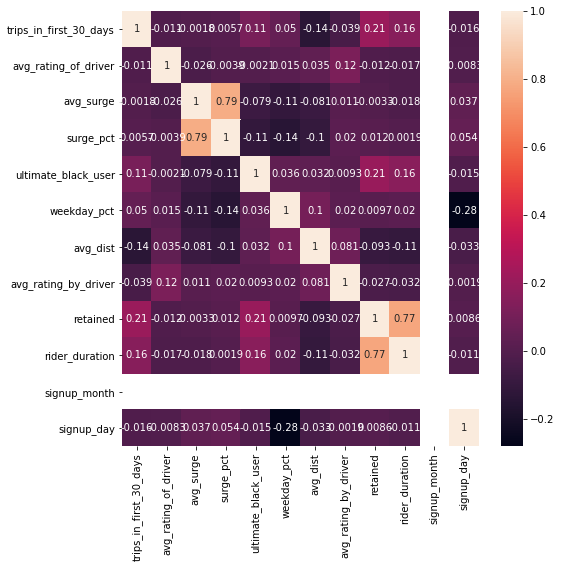

In [79]:
plt.figure(figsize=(8,8))
sns.heatmap(ultimate_data.corr(),annot=True);

### Basic Feature Engineering:
1. 

In [80]:
ultimate_data['signup_month'] = ultimate_data['signup_date'].dt.month
ultimate_data['signup_day'] =  np.where(ultimate_data['signup_date'].dt.dayofweek < 5, 0, 1)
#weekday =0, weekend = 1

In [81]:
ultimate_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    50000 non-null  category       
 1   trips_in_first_30_days  50000 non-null  int64          
 2   signup_date             50000 non-null  datetime64[ns] 
 3   avg_rating_of_driver    41878 non-null  float64        
 4   avg_surge               50000 non-null  float64        
 5   last_trip_date          50000 non-null  datetime64[ns] 
 6   phone                   49604 non-null  category       
 7   surge_pct               50000 non-null  float64        
 8   ultimate_black_user     50000 non-null  bool           
 9   weekday_pct             50000 non-null  float64        
 10  avg_dist                50000 non-null  float64        
 11  avg_rating_by_driver    49799 non-null  float64        
 12  days_since_last_trip    50000 no

In [154]:
#RUN1: drop null values
ultimate_subset = ultimate_data.dropna()
ultimate_subset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 41445 entries, 0 to 49998
Data columns (total 17 columns):
 #   Column                  Non-Null Count  Dtype          
---  ------                  --------------  -----          
 0   city                    41445 non-null  category       
 1   trips_in_first_30_days  41445 non-null  int64          
 2   signup_date             41445 non-null  datetime64[ns] 
 3   avg_rating_of_driver    41445 non-null  float64        
 4   avg_surge               41445 non-null  float64        
 5   last_trip_date          41445 non-null  datetime64[ns] 
 6   phone                   41445 non-null  category       
 7   surge_pct               41445 non-null  float64        
 8   ultimate_black_user     41445 non-null  bool           
 9   weekday_pct             41445 non-null  float64        
 10  avg_dist                41445 non-null  float64        
 11  avg_rating_by_driver    41445 non-null  float64        
 12  days_since_last_trip    41445 no

In [225]:
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.pipeline import Pipeline

from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


#### RUN1 dropna()

In [190]:
#drop datetimes, and features that are highly correlated to others in the dataset:
features = ultimate_subset.drop(['signup_date','last_trip_date', 'days_since_last_trip',
                                'surge_pct', 'rider_duration'], axis=1)

In [191]:
features_used = pd.get_dummies(features)

In [195]:
def cross_val_models(df):
    X = df.drop('retained', axis=1)
    y = df['retained']

    cross_val_avg_all=[]
    cv = ShuffleSplit(n_splits=5, test_size=0.3, random_state=12)

    cross_val_logreg = cross_validate(LogisticRegression(max_iter=1000),X, y, cv=cv, scoring=['f1','accuracy'])
    cross_val_rf = cross_validate(RandomForestClassifier(n_estimators=100), X, y, cv=cv, scoring=['f1','accuracy'])

    #Calculate mean of all 5batches of cross-validation for all feature dataframes:
    cross_val_avg =[np.mean(cross_val_logreg['test_f1']),
                               np.mean(cross_val_logreg['test_accuracy']),
                       np.mean(cross_val_rf['test_f1']),
                               np.mean(cross_val_rf['test_accuracy'])
                                       ]
    cross_val_avg_all.append(cross_val_avg)
    
    cross_val_avg_all_df = pd.DataFrame(cross_val_avg_all, index=['scores'],columns=['Logreg_f1', 'Logreg_accuracy', 'RF_f1', 'RF_accuracy']).transpose()
    return cross_val_avg_all_df

In [209]:
features_xval_table = cross_val_models(features_used)

In [160]:
cross_val_avg_all_sa_df = pd.DataFrame(cross_val_avg_all_sa, index=['scores'],columns=['Logreg_f1', 'Logreg_accuracy', 'RF_f1', 'RF_accuracy']).transpose()
cross_val_avg_all_sa_df

,scores
Logreg_f1,0.602571
Logreg_accuracy,0.704263
RF_f1,0.687295
RF_accuracy,0.745102


In [146]:
features2 = ultimate_data.drop(['signup_date','last_trip_date', 'days_since_last_trip',
                                'surge_pct', 'rider_duration'], axis=1)

In [162]:
features2.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 12 columns):
 #   Column                  Non-Null Count  Dtype   
---  ------                  --------------  -----   
 0   city                    50000 non-null  category
 1   trips_in_first_30_days  50000 non-null  int64   
 2   avg_rating_of_driver    50000 non-null  float64 
 3   avg_surge               50000 non-null  float64 
 4   phone                   49604 non-null  category
 5   ultimate_black_user     50000 non-null  bool    
 6   weekday_pct             50000 non-null  float64 
 7   avg_dist                50000 non-null  float64 
 8   avg_rating_by_driver    49799 non-null  float64 
 9   retained                50000 non-null  int64   
 10  signup_month            50000 non-null  int64   
 11  signup_day              50000 non-null  int32   
dtypes: bool(1), category(2), float64(5), int32(1), int64(3)
memory usage: 3.4 MB


#### RUN2: Fillna with mean values:

In [205]:
features2['avg_rating_of_driver'] = features2['avg_rating_of_driver'].fillna(features2['avg_rating_of_driver'].mean())
features2['avg_rating_by_driver'] = features2['avg_rating_by_driver'].fillna(features2['avg_rating_by_driver'].mean())

In [206]:
features2_used = pd.get_dummies(features2)

In [207]:
features2_used.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 15 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   trips_in_first_30_days  50000 non-null  int64  
 1   avg_rating_of_driver    50000 non-null  float64
 2   avg_surge               50000 non-null  float64
 3   ultimate_black_user     50000 non-null  bool   
 4   weekday_pct             50000 non-null  float64
 5   avg_dist                50000 non-null  float64
 6   avg_rating_by_driver    50000 non-null  float64
 7   retained                50000 non-null  int64  
 8   signup_month            50000 non-null  int64  
 9   signup_day              50000 non-null  int32  
 10  city_Astapor            50000 non-null  uint8  
 11  city_King's Landing     50000 non-null  uint8  
 12  city_Winterfell         50000 non-null  uint8  
 13  phone_Android           50000 non-null  uint8  
 14  phone_iPhone            50000 non-null

In [210]:
features2_xval_table = cross_val_models(features2_used)

In [212]:
features2_xval_table

,scores
Logreg_f1,0.570491
Logreg_accuracy,0.718347
RF_f1,0.666657
RF_accuracy,0.754600


In [213]:
features_xval_table

,scores
Logreg_f1,0.602571
Logreg_accuracy,0.704263
RF_f1,0.687428
RF_accuracy,0.745392


Filling 'avg_rating_of_driver', and 'avg_rating_of_driver' with the mean of the column, instead of dropping all rows with missing values improved the accuracy, but reduced f1 (as seen above).<br>
Random Forest(74% accuracy) gave better results than LogisticRegression(70% accuracy).<br>
Next step, is to improve the RF model by hyper-parameter tuning.<br>

In [177]:
cross_val_avg_all_df = pd.DataFrame(cross_val_avg_all, index=['scores'],columns=['Logreg_f1', 'Logreg_accuracy', 'RF_f1', 'RF_accuracy', 'gbc_f1','gbc_acc']).transpose()
cross_val_avg_all_df

,scores
Logreg_f1,0.602571
Logreg_accuracy,0.704263
RF_f1,0.688301
RF_accuracy,0.746132
gbc_f1,0.718934
gbc_acc,0.774425


In [218]:
X = features_used.drop('retained', axis=1)
y = features_used['retained']
X_train,X_test, y_train, y_test = train_test_split(X,y, test_size=0.3,random_state=890)

In [221]:
# hyper-tune RF parameters

model_params = {
    'n_estimators': [50, 150, 250, 350],   
    'min_samples_split': [2, 4, 6]
}

# create random forest classifier model
rf_model = RandomForestClassifier(random_state=890)

# set up grid search meta-estimator
clf = GridSearchCV(rf_model, model_params, scoring='f1', cv=5)

# train the grid search meta-estimator to find the best model
model = clf.fit(X_train, y_train)

# print winning set of hyperparameters
from pprint import pprint
pprint(model.best_estimator_.get_params())

print('Best parameters:', model.best_params_)
print('Corresponding f1 score: ', model.best_score_)

{'bootstrap': True,
 'ccp_alpha': 0.0,
 'class_weight': None,
 'criterion': 'gini',
 'max_depth': None,
 'max_features': 'auto',
 'max_leaf_nodes': None,
 'max_samples': None,
 'min_impurity_decrease': 0.0,
 'min_impurity_split': None,
 'min_samples_leaf': 1,
 'min_samples_split': 6,
 'min_weight_fraction_leaf': 0.0,
 'n_estimators': 350,
 'n_jobs': None,
 'oob_score': False,
 'random_state': 890,
 'verbose': 0,
 'warm_start': False}
Best parameters: {'min_samples_split': 6, 'n_estimators': 350}
Corresponding f1 score:  0.7011310114107447


In [226]:
rf_model = RandomForestClassifier(n_estimators=350, min_samples_split=6,random_state=890)

# Modeling code in a pipeline
pipe= Pipeline(steps=[('model', rf_model)])

#Split data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=890)


# fit model 
pipe.fit(X_train, y_train)

# Get predictions
model_preds = pipe.predict(X_test)

# Evaluate the model
print('Accuracy=', accuracy_score(y_test, model_preds))
print(confusion_matrix(y_test, model_preds))
print(classification_report(y_test, model_preds))

Accuracy= 0.7588064983110825
[[5907 1341]
 [1658 3528]]
              precision    recall  f1-score   support

           0       0.78      0.81      0.80      7248
           1       0.72      0.68      0.70      5186

    accuracy                           0.76     12434
   macro avg       0.75      0.75      0.75     12434
weighted avg       0.76      0.76      0.76     12434



In [229]:
# Extract most important features:
feature_imp = pd.Series(rf_model.feature_importances_).sort_values(ascending=False)
#pd.DataFrame(feature_imp)

In [230]:
feature_imp

5     0.218403
4     0.156701
6     0.142657
2     0.108274
0     0.083596
1     0.080185
10    0.061205
3     0.044441
12    0.027638
13    0.025234
9     0.021647
8     0.015427
11    0.014592
7     0.000000
dtype: float64

In [237]:
# Feature importance ranking of hypertuned RandomForest 
feature_imp = pd.DataFrame({'feature': X_train.columns, 'importance': pipe[0].feature_importances_})
print(feature_imp.sort_values(by='importance',ascending=False)[:3])


                feature  importance
5              avg_dist    0.218403
4           weekday_pct    0.156701
6  avg_rating_by_driver    0.142657


### Business actionables:
- Average distance of the trip seems to be a very important factor. Perhaps more can be done(advertising, insentives) to attract riders from more distant cities.<br>
- Look into what prompts drivers to give higher ratings. That would provide a clue as to how the company can boost those.<br>
- Similar plan to boost weekday riders (perhaps through lower rates at certain times).